In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import warnings
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Ignore warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the path for the train and test images
# import pathlib
import pathlib

train_path = pathlib.Path('/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
test_path = pathlib.Path('/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
# Now read all jpg files from test and train path
import glob

train_images = list(train_path.glob('*/*.jpg'))
test_images = list(test_path.glob('*/*.jpg'))
print('Total number of train images ', len(train_images))
print('Total number of test images ', len(test_images))

Total number of train images  2239
Total number of test images  118


In [ ]:
# Now we load train dataset into memory from disk using image_dataset_from_directory utility.
# This will create a pipeline for each sub folders under a parent directory passed in the directory parameter
# This returns a tensor dataset of images for each classes
# We also ensure to resize images to 180*180 and of batch size 32
from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
img_height = 180
img_width = 180

train_ds = image_dataset_from_directory(
    train_path,
    label_mode='categorical',
    validation_split = 0.2,
    batch_size =batch_size,
    image_size = (img_height, img_width),
    subset = 'training',
    seed = 123
)
train_ds.class_names


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
# Validation Dataset
val_ds = image_dataset_from_directory(
    train_path,
    label_mode='categorical',
    validation_split = 0.2,
    batch_size =batch_size,
    image_size = (img_height, img_width),
    subset = 'validation',
    seed = 123
)
val_ds.class_names

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Data Visualization
---
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:

# Dictionary to hold one image per category
image_catalog = {}


# Loop through the validation dataset and add each image and their respective classes in a dictionary
# Add to distionary only if the image class is not present in the dictionary
# Once the dictionary size = No of classes break the loop
for images, labels in val_ds:
    for img, label in zip(images, labels):
        label_value = tuple(label.numpy())
        image_value = img.numpy().astype("uint8")
        # If the number of keys in the dictionary = no of classes then exit
        if len(image_catalog) == len(val_ds.class_names):
          break
        if label_value not in image_catalog:
          # Add the image to the dictionary
          image_catalog[label_value] = image_value

print('Number of distinct classes captured in the distionary image_catalog is ', len(image_catalog))

Number of distinct classes captured in the distionary image_catalog is  9


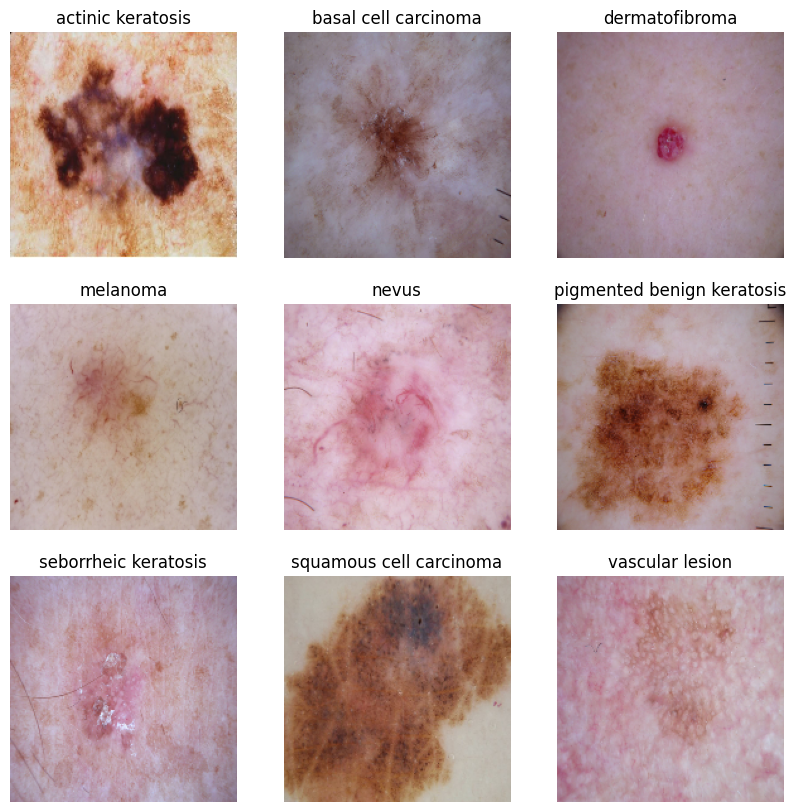

In [ ]:
# As we have captured all 9 classes in dictionary image_catalog we can easily show them.

# Get class names
class_names = val_ds.class_names

fig = plt.figure(figsize=(10, 10))
for i, (label, img) in enumerate(image_catalog.items()):
    ax = fig.add_subplot(3, 3, i + 1)  # Adjust subplot grid size if necessary
    plt.imshow(img)
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# CNN Model Architecture
model = Sequential()

# Rescaling of pixel values between 0 and 1
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

# Now we will build ConV2D layers with 32 filters and RELU activation function followed by a amax pooling layer
# Then another conv2D layer with 64 filters followed by another max pooling layer
# 128 dense FC layer
# Softmax layer with 9 neurons

#Conv Layer - 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
# Max Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer - 2
model.add(Conv2D(64, (3, 3), activation='relu'))
# Max Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Dense layer
model.add(Dense(128, activation='relu'))

# Softmax layer
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 118336)            0

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 20
history = model.fit(
    batch_size=32,
    x=train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/20
56/56 [==============================] - 533s 97ms/step - loss: 2.9552 - accuracy: 0.2031 - val_loss: 1.9013 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 1.8548 - accuracy: 0.3108 - val_loss: 1.9490 - val_accuracy: 0.3065
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.7940 - accuracy: 0.3443 - val_loss: 1.6228 - val_accuracy: 0.4072
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6594 - accuracy: 0.3856 - val_loss: 1.6110 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4372 - accuracy: 0.5000 - val_loss: 1.5635 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3122 - accuracy: 0.5480 - val_loss: 1.4705 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.2862 - accuracy: 0.5441 - val_loss: 1.5675 - val_accuracy: 0.4810
Epoch 8/20


### Visualizing training results

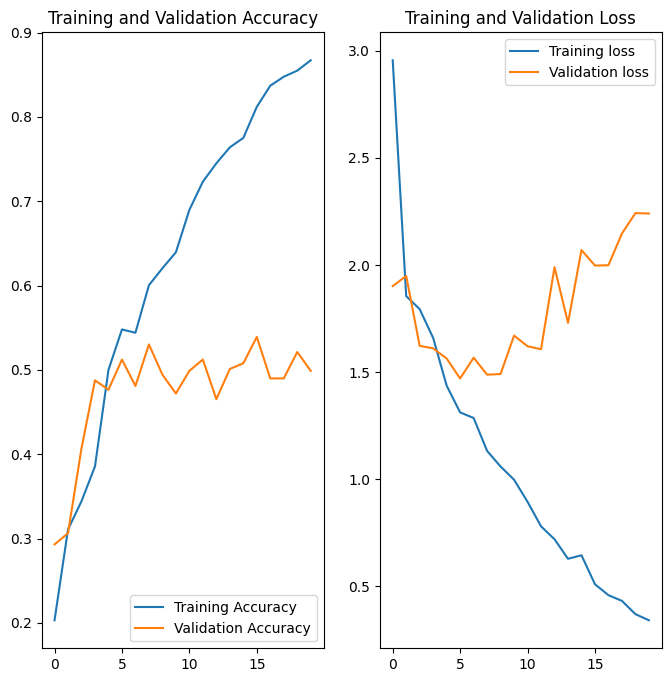

In [ ]:
# Show history
# Capture Validation and Train Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig = plt.figure(figsize=(8, 8))

# Plot training and validation accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training loss')
plt.plot(epochs_range,val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Observations
---
After the 1st model we can clearly find that the model is significantly overfits on the training data.The training accuracy goes upto 86% and the validation accuracy drops to less than 50%.
From the history also we cn visualize that after 5 epochs the difference in accuracy between traing and validation data set gets larger and larger.
We can try to tackle this in 2 ways



1.   ***Train data handling*** - We may check if their is any class imabalce
issue in the training data nd if so with the introduction of augmentor we can try to curb that out.
2.   ***Model update*** - We can add dropouts, add regulerization factor with learning rate, batch normalizations




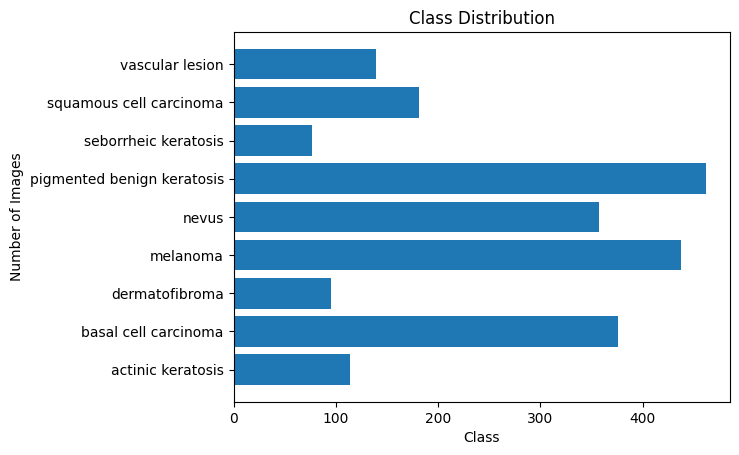

In [ ]:
# Training data handling
# Visualize class imabalance. Here we would like to find out the distribution of images for each class in the training dataset.
# Create a dictionary that will contain the classname as key and no of images as value
class_distribution = {}
for path in train_path.iterdir():
    if path.is_dir():
        class_name = path.name
        class_distribution[class_name] = len(list(path.iterdir()))

# Create a bar chart
plt.barh(list(class_distribution.keys()), list(class_distribution.values()))
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()



#### As we can see there is few class imbalance factors as the number of images for each class not well distributed.


*   Class `seborrheic keratosis` has least number of images
*   class `pigmented benign keratosis` has most number of iamages

We will use python package known as `Augmentor` to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
# install Augmentor
!pip install Augmentor

In [ ]:
for class_path in train_path.iterdir():
    print(os.path.join(train_path, class_path))

/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
/content/dr

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [ ]:
# import augmentor
import Augmentor

# instantiate pipeline for each class path
for class_path in train_path.iterdir():
    if class_path.is_dir():

      output_directory = os.path.join(train_path,class_path, 'output')
      # If Output directory exists then skip this iteration
      if not os.path.exists(output_directory):
        p = Augmentor.Pipeline(os.path.join(train_path,class_path))
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500) # sample 500 images per class


### Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
len(list(train_path.glob('*/output/*.jpg')))

4500

### Lets see the distribution of augmented data after adding new images to the original training data.

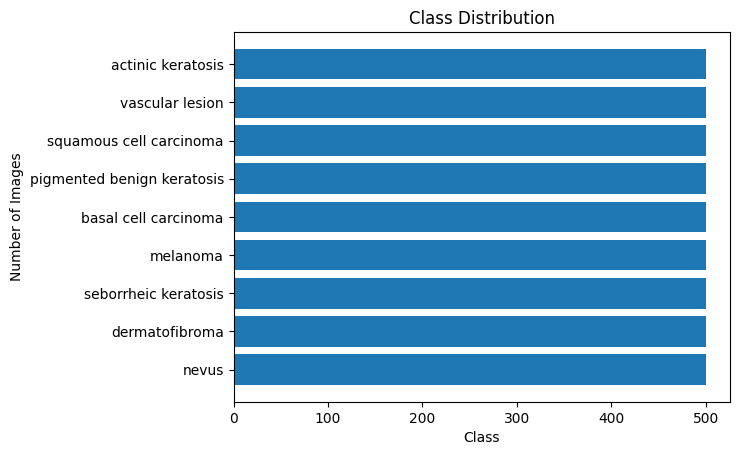

In [ ]:
class_distribution = {}

for path in train_path.iterdir():
    if path.is_dir():
      class_name = path.name
      for path in path.iterdir():
          if path.is_dir() and path.name == 'output':
            class_distribution[class_name] = len(list(path.iterdir()))
# Create a bar chart
plt.barh(list(class_distribution.keys()), list(class_distribution.values()))
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()


# We will create a standard directory with all the augmented images for each class

In [ ]:
# Create Train_Augmented for each class
if not os.path.exists(os.path.join('/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration', 'Train_Augmented')):
  os.makedirs(os.path.join('/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration', 'Train_Augmented'), exist_ok=True)


In [ ]:
train_aug_path =   os.path.join('/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration', 'Train_Augmented')
train_aug_path

'/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented'

In [ ]:
import shutil

# Copy the images from the output directory and place it Train_Augmented/ClassName folder
for class_path in train_path.iterdir():
  # Check if a class folder is availabe under Train_Augmented for this class, if not create one. This is going to be our target folder
  if not os.path.exists(os.path.join(train_aug_path, class_path.name)):
    os.makedirs(os.path.join(train_aug_path, class_path.name))
  Target_dir =   os.path.join(train_aug_path, class_path.name)
  print(Target_dir)

  # Copy the images from the output directory and place it Train_Augmented/ClassName folder
  files = os.listdir(os.path.join(class_path, 'output'))
  for img in files:
    shutil.copy(os.path.join(class_path, 'output', img), Target_dir)



/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/nevus
/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/dermatofibroma
/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/seborrheic keratosis
/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/melanoma
/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/basal cell carcinoma
/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/pigmented benign keratosis
/content/drive/MyDrive/Cancer Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmente

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_width = 180
img_height = 180

#### **Todo:** Create a training dataset

In [ ]:
train_ds = image_dataset_from_directory(
    train_aug_path,
    label_mode='categorical',
    validation_split = 0.2,
    batch_size =batch_size,
    image_size = (img_height, img_width),
    subset = 'training',
    seed = 123
)
print(train_ds.class_names)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = image_dataset_from_directory(
    train_aug_path,
    label_mode='categorical',
    validation_split = 0.2,
    batch_size =batch_size,
    image_size = (img_height, img_width),
    subset = 'validation',
    seed = 123
)
print(val_ds.class_names)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture


model = Sequential()
# Scale pixels between 0 and 1
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

# Conv layer 1
model.add(layers.Conv2D(32,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(32,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))

# Conv layer 2
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))

# Batch normalization
model.add(layers.BatchNormalization())

# Dropout layer with .25 drop rate
model.add(layers.Dropout(0.25))


# Conv layer 3
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))


# Batch normalization
model.add(layers.BatchNormalization())

# Dropout layer with .4 drop rate
model.add(layers.Dropout(0.4))

#Flatten Layer
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(256,activation='relu'))

# Dropout layer with .25 drop rate
#model.add(layers.Dropout(0.25))

# output dense  layer with softmax activation function.

model.add(layers.Dense(9,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 41, 41, 64)       

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 50
history = model.fit(
    batch_size=32,
    x=train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/50
113/113 [==============================] - 37s 99ms/step - loss: 2.0289 - accuracy: 0.3517 - val_loss: 2.1709 - val_accuracy: 0.1367
Epoch 2/50
113/113 [==============================] - 5s 43ms/step - loss: 1.5954 - accuracy: 0.4267 - val_loss: 2.7727 - val_accuracy: 0.1556
Epoch 3/50
113/113 [==============================] - 5s 44ms/step - loss: 1.3539 - accuracy: 0.5058 - val_loss: 2.1276 - val_accuracy: 0.2400
Epoch 4/50
113/113 [==============================] - 5s 44ms/step - loss: 1.2374 - accuracy: 0.5483 - val_loss: 1.8690 - val_accuracy: 0.2922
Epoch 5/50
113/113 [==============================] - 5s 43ms/step - loss: 1.1504 - accuracy: 0.5706 - val_loss: 1.9826 - val_accuracy: 0.3656
Epoch 6/50
113/113 [==============================] - 5s 45ms/step - loss: 1.0206 - accuracy: 0.6219 - val_loss: 2.4716 - val_accuracy: 0.3000
Epoch 7/50
113/113 [==============================] - 5s 44ms/step - loss: 0.9738 - accuracy: 0.6431 - val_loss: 1.4883 - val_accuracy: 0.473

#### **Todo:**  Visualize the model results

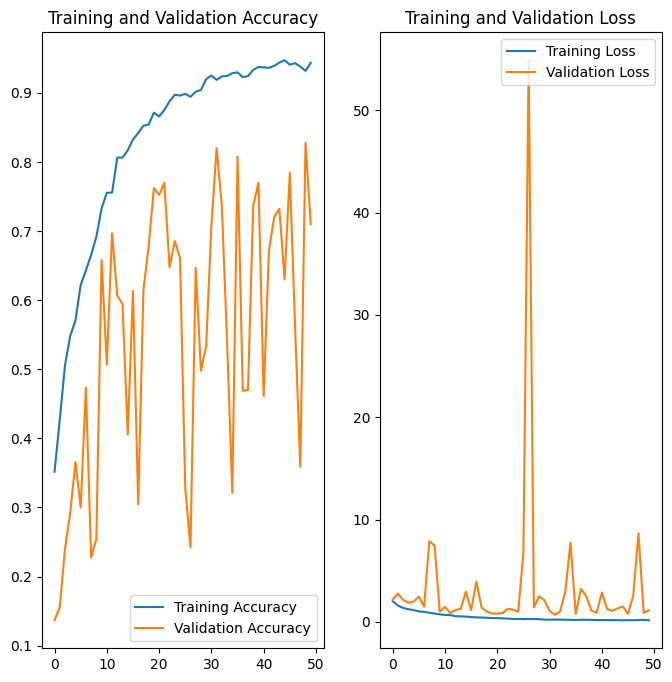

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze Result here
---
After few trials and error I settled with the model architecture of
1. Conv 2d with 32 filters
2. Max pooling layer
3. Conv 2d with 32 filters
4. Max pooling layer
5. Conv 2d with 64 filters
6. Max pooling layer
7. Conv 2d with 64 filters
8. Max pooling layer
9. A batch normalization layer
10. A drop out layer with 25% drop out rate
11. Last conv 2d layer with 128 filters
12. Max pooling layer
13. Second batch normalization layer
14. Second dropout layer with 40% drop out rate
15. Flattening layer
16. 1st dense layer with 256 neurons
17. Last dropout layer with 40% dropout rate
18. Softmax output layer

#### We still observe the model shows overfitting trend although we are able to raise the validation accuracy to 76%. With further trail and optimization of the network the overfitting trend can be curbed down.We run 50 epochs.
